# Introduction

This notebook seeks to develop a model that can predict medical charges faced by individuals using features such as Age, Sex, BMI, number of Children, Smoker, and Region. An XGBoost regressor model is chosen, that is trained using randomized grid-search and early stopping, with its performance being evaluated using k-fold validation.

## **About Dataset**
Information provided on the data set page.


**Overview of the dataset:**\
The medical insurance dataset contains information about a number of factors that can affect medical expenses, including age, sex, BMI, smoking status, number of children, and region. This dataset can be used to train a machine learning model that can predict medical expenses for new customers.

To provide insights into the key factors that contribute to higher insurance costs and help the company make more informed decisions regarding pricing and risk assessment.

The dataset contains **2.7K rows and 7 columns**
Columns include

1. Age
2. Sex
3. BMI (Body Mass Index)
4. Children
5. Smoker
6. Region
7. Charges

**Problem Statement:**

1. What are the most important factors that affect medical expenses?
2. How well can machine learning models predict medical expenses?
3. How can machine learning models be used to improve the efficiency and profitability of health insurance companies?

## Import modules and loading data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from xgboost import XGBRegressor, cv, DMatrix, plot_importance
%matplotlib inline

In [2]:
path = r"/kaggle/input/medical-insurance-price-prediction/Medical_insurance.csv"
df = pd.read_csv(path)

# 1 | Exploratory Data Analysis
Examining features, data types, missing values etc.

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The structure of the data set.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


As described in the introduction, it is a rather small data set with seven columns and a total of 2772 rows. There does not appear to be any missing values. The features consists of three numerical variables and three categorical variables, and the target variable is continuous.

In [5]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


Selected statistics for the numerical columns.
* Age contains values between 18 to 64 years, so we are only considering adult individuals.
* bmi spans from 16 to 53 with a mean of 31, and there appear to be a large variability considering the quantiles.
* children is a discrete numerical variable, where people in the data set have between zero to five kids.
* charges, the target variable, spans a wide range from 1122 to 63770, and it seems to be quite skewed comparing the mean to the median.

## Categorical Features

<Axes: xlabel='sex', ylabel='count'>

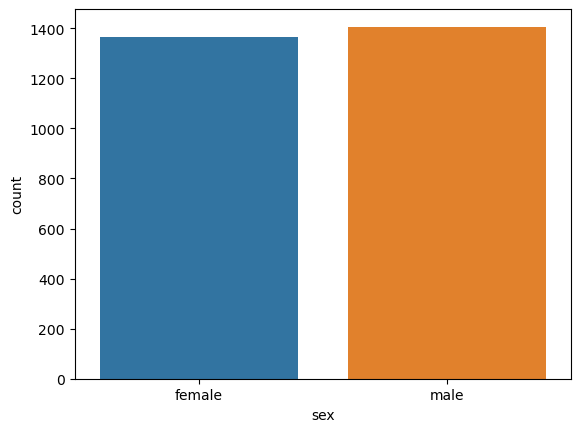

In [6]:
sns.countplot(x=df["sex"])

The data set seems to have an equal representation of females and males.

<Axes: xlabel='smoker', ylabel='count'>

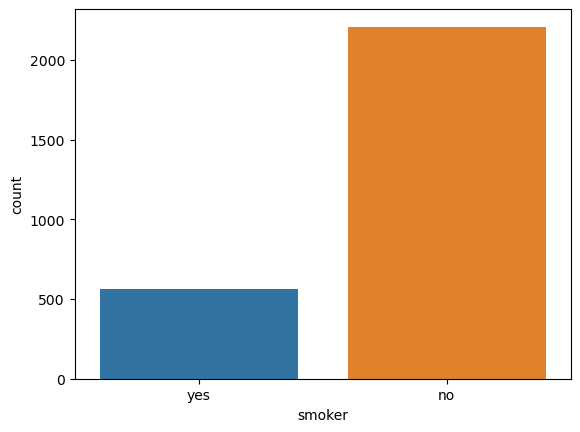

In [7]:
sns.countplot(x=df["smoker"])

There are around four times as many non-smokers as smokers in the data set.

<Axes: xlabel='region', ylabel='count'>

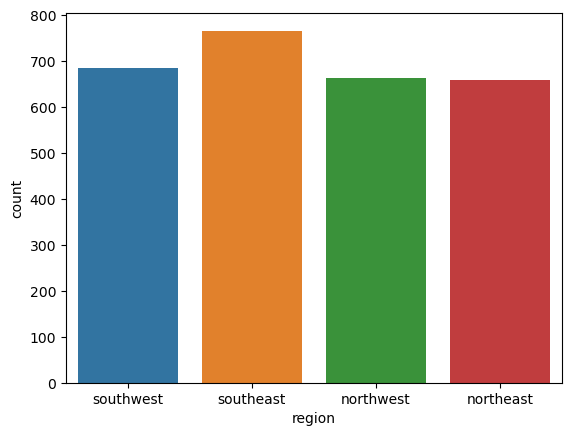

In [8]:
sns.countplot(x=df["region"])

The four regions are quite equally represented.

# 2 | Data Preprocessing

With no missing values and no feature engineering used, this section is rather short. 

## Dummy Variables

In [9]:
df = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)

## Correlation Analysis

Having converted the categorical features to dummy variables, we can consider the correlations.

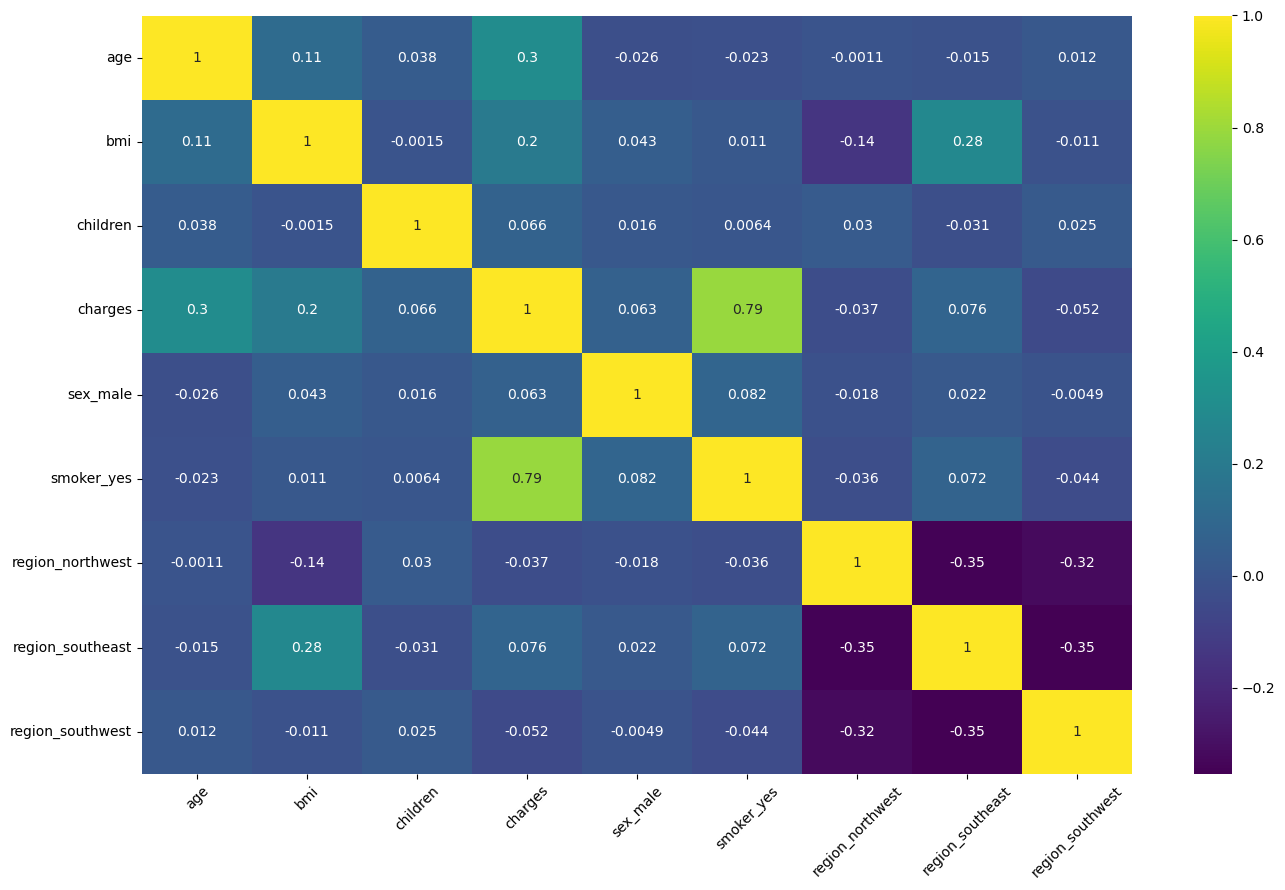

In [10]:
plt.figure(figsize=(14, 9))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("charges", axis=1).values, df["charges"].values, train_size=0.8)

# 3 | Model
XGBoost Regressor | Grid Search | K-fold CV

## Finding Optimal Parameters
Using randomized grid search

First an XGBRegressor object is created to be used for prediction of continuous values. Only a few parameters are set, as the rest will be found using randomized grid search.

In [12]:
xgb = XGBRegressor(n_estimators=500, n_jobs=4)

Defining the parameter space of which a subset will be tested through searching and the best of those tested will be used.

In [13]:
param_grid = {
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1],
    "gamma": [0.5, 1, 1.5, 3],
    "colsample_bytree": [0.6, 0.8, 1.0]
}


Additional parameters for the fitting process. In this case, they are simply related to the early stopping process, i.e. the training will halt if the performance on the test set has not improved after a selected number of rounds.

In [14]:
fit_params = {
    "eval_set":[(X_test, y_test)], 
    "early_stopping_rounds": 10,
    "eval_metric": "rmse"
}

Object for K-fold cross validation.

In [15]:
kf = KFold(n_splits=5, shuffle = True, random_state = 42)

Creating a random search CV object to search the defined parameter space using K-fold cross validation to find the optimal parameter set. A total of 10 parameter sets are tested from the defined parameter space.

In [16]:
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10, scoring="neg_mean_squared_error", n_jobs=4, cv=kf.split(X_train,y_train), verbose=0, random_state=42)

This search can take some time, so as an alternative to running this calibration one can select a random combination of the parameter set or e.g. use the following:\
best_params = {'subsample': 1,
 'learning_rate': 0.05,
 'gamma': 0.5,
 'colsample_bytree': 1.0}

Running the fit method on the training data set. Usually, a train-test split is not needed for K-fold cross validation, however it is used here for the early stopping process.

In [ ]:
random_search.fit(X_train, y_train, **fit_params)

## Evaluating Performance
Using K-fold Cross Validation

The best set of parameters identified from the random grid search.

In [18]:
random_search.best_params_

{'subsample': 0.8, 'learning_rate': 0.05, 'gamma': 3, 'colsample_bytree': 0.8}

Creating the data set for the final K-fold cross validation of the model.

In [19]:
data = DMatrix(data=df.drop("charges", axis=1), label=df["charges"], feature_names=df.drop("charges", axis=1).columns)

For the final validation, the best set of parameters determined from the randomized search is used.

In [20]:
params_final = {**{"objective": "reg:squarederror", "n_jobs": 4, "eval_metric": "rmse"}, **random_search.best_params_}
xgb_cv = cv(dtrain=data, params=params_final, nfold=5, num_boost_round=500, early_stopping_rounds=10)

Looking at performance by looking at the RMSE on the last iteration.

In [21]:
xgb_cv.tail(1)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
499,1138.141175,56.84164,2591.112948,350.601182


Note: Since early stopping did not stop the training, better performance could likely be obtained using a higher number of rounds. However, to stay consistent, the same number of rounds were used here as for the randomized grid search, and increasing the number of rounds in the grid search would make the process become even more time consuming.

## Feature Importance

In order to determine the feature importance, a new XGBRegressor object is created with the best parameters (as far as I know, the cross-validation class does not have this method).

In [22]:
xgb_ = XGBRegressor(n_estimators=500, n_jobs=4, **random_search.best_params_)

In [23]:
xgb_.fit(X=df.drop("charges", axis=1), y=df["charges"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=4, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

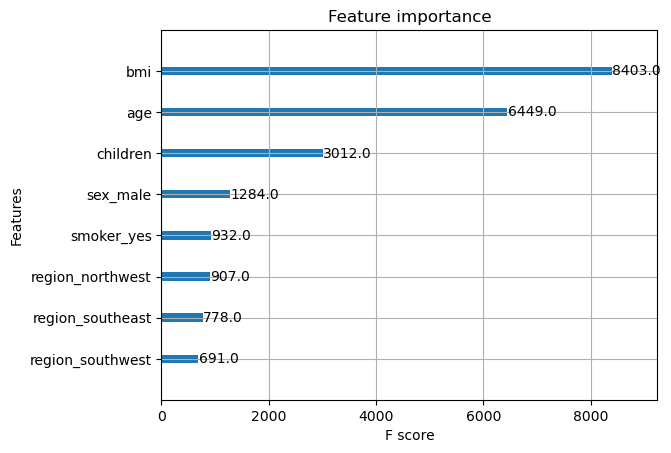

In [24]:
plot_importance(xgb_)


As seen from the plot above, the BMI and age of the insurance buyer seem to be the most relevant factors for the charged price.